In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



# Objective

The objective of this project is to help researchers in their research. Each researcher has to skim through a lot of research papers trying to find the relevant ones to the topic in their mind. And in doing so they have to read the abstracts of papers to filter the relevant ones. But sometimes it becomes time-consuming if the abstract don't have proper structure. 

Following research paper focuses on this problem specifically for Medical domain. This paper converts the unstructured PubMed-RCT-abstracts into structured form using Machine learning. Please read through the paper for better understanding of the usecase.

📖 https://arxiv.org/pdf/1710.06071.pdf

📖 https://arxiv.org/pdf/1612.05251.pdf

My contribution is to implement the usecase using the current State-of-the-art architecture (BERT) and achieve better results.

## Get the data

The dataset I am using was prepared by the authors of the Research paper. You can download it from his Github link: https://github.com/Franck-Dernoncourt/pubmed-rct

There are 2 version of the dataset:
1. Larger: PubMed_200k_RCT which contains 200k labelled sentences of abstracts in total. There is also a version of this dataset where the numbers mentioned in the abstract is replaced by `@` symbol.

2. Smaller: PubMed_20K_RCT which contains 20k labelled sentences of abstracts in total. There is also a version of this dataset where the numbers mentioned in the abstract is replaced by `@` symbol.

I'll be using the Smaller version (PubMed_20K_RCT) for this project.

In [ ]:
# Clone the repo
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.


In [ ]:
# Check the files in the directory
import os
os.listdir('/content/pubmed-rct')

['README.md',
 'PubMed_200k_RCT',
 '.git',
 'PubMed_20k_RCT',
 'PubMed_20k_RCT_numbers_replaced_with_at_sign',
 'PubMed_200k_RCT_numbers_replaced_with_at_sign']

In [ ]:
# Check the files of our concerned directory
target_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'
os.listdir(target_dir)

['dev.txt', 'train.txt', 'test.txt']

So the dataset is already divided into Train, Dev & Test sets. Let's read in the files and preprocess the data.

## Preprocess the data

Before preprocessing, it is better to visualize how our data looks like.


In [ ]:
with open(target_dir + 'train.txt') as f:
  train_text = f.readlines()

In [ ]:
train_text[:28]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
# Length of train data
len(train_text)

210040

So the dataset has 5 labels namely:
* **BACKGROUND**
* **OBJECTIVE**
* **METHODS**
* **RESULTS**
* **CONCLUSIONS**

and is represented in the following format:
```
'###24293578\n' -> id denoting start of abstract of a research paper
(Label)\t(Sentence) -> Label along with each sentence in the abstract
(Label)\t(Sentence)
.
.
'\n' -> denoting the end of abstract of research paper
```

To represent data in a better, I'll add 2 features i.e. 
* Line_number of each sentence in the abstract. This is because sequence of the sentences in the abstract matters a lot. A sentence with label **`RESULTS`** won't end up before **`OBJECTIVE`** sentence.
* Total number of sentences in the abstract.

So each line should have following format:
```
[{'line_number':0,
  'label':'BACKGROUND',
  'text':'Emotional eating is associated with overeating and the development of obesity .\n',
  'total_lines':11}, 
....]
```

In [ ]:
# Function to read in the target files
def preprocess_text(filename):
  """
  Reads in the filename and returns a structured dictionary format for each line in text

  params: filename - Name/path of the file to be read
  return: List of dictionaries
  """
  with open(filename) as f:
    input_lines = f.readlines()
  
  abstract_text = ''
  abstract_samples = []

  for line in input_lines:
    if line.startswith('###'):
      abstract_text = ''

    elif line.isspace():
      abstract_text_split = abstract_text.splitlines()

      for line_num, abstract_line_text in enumerate(abstract_text_split):
        line_dict = {}
        label, text = abstract_line_text.split('\t')[0], abstract_line_text.split('\t')[1]
        line_dict['line_number'] = line_num
        line_dict['target_label'] = label
        line_dict['text'] = text
        line_dict['total_lines'] = len(abstract_text_split) - 1 # considering line_number starts with 0
        abstract_samples.append(line_dict)

    else:
      abstract_text += line

  return abstract_samples

In [ ]:
# Preprocessing the data
%%time
train_data = preprocess_text(target_dir + 'train.txt')
dev_data = preprocess_text(target_dir + 'dev.txt')
test_data = preprocess_text(target_dir + 'test.txt')

CPU times: user 450 ms, sys: 80 ms, total: 530 ms
Wall time: 531 ms


In [ ]:
# Check the length of each portion of dataset
len(train_data), len(dev_data), len(test_data)

(180040, 30212, 30135)

In [ ]:
train_data[:12]

[{'line_number': 0,
  'target_label': 'OBJECTIVE',
  'text': 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target_label': 'METHODS',
  'text': 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target_label': 'METHODS',
  'text': 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target_label': 'METHODS',
  'text': 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target_label': 'METHODS',
  'text': 'Seco

In [ ]:
# Let's visualize the data in a dataframe
import pandas as pd

train_df = pd.DataFrame(train_data)
dev_df = pd.DataFrame(dev_data)
test_df = pd.DataFrame(test_data)

train_df.head(15)

,line_number,target_label,text,total_lines
0,0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,A total of @ patients with primary knee OA wer...,11
2,2,METHODS,Outcome measures included pain reduction and i...,11
3,3,METHODS,Pain was assessed using the visual analog pain...,11
4,4,METHODS,Secondary outcome measures included the Wester...,11
5,5,METHODS,"Serum levels of interleukin @ ( IL-@ ) , IL-@ ...",11
6,6,RESULTS,There was a clinically relevant reduction in t...,11
7,7,RESULTS,The mean difference between treatment arms ( @...,11
8,8,RESULTS,"Further , there was a clinically relevant redu...",11
9,9,RESULTS,These differences remained significant at @ we...,11


In [ ]:
# Target labels
classes = train_df['target_label'].unique()
num_classes = len(classes)
print(f'There are {num_classes} target labels namely: {classes}')

There are 5 target labels namely: ['OBJECTIVE' 'METHODS' 'RESULTS' 'CONCLUSIONS' 'BACKGROUND']


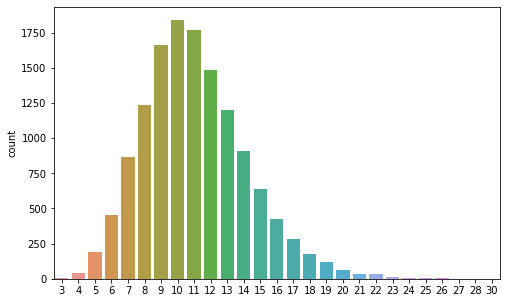

In [ ]:
# Visualize the length of abstract in terms of lines
from itertools import groupby
import matplotlib.pyplot as plt
import seaborn as sns
abstract_lengths = [x[0] for x in groupby(train_df['total_lines'].tolist())]

plt.figure(figsize=(8,5))
sns.countplot(x=abstract_lengths);

Most abstracts have 9-12 sentences in them while the maximum number of sentences is 30 and minimum is 3.

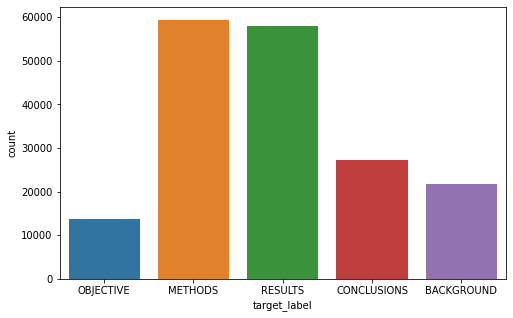

In [ ]:
# Visualize the number of sentences per label
plt.figure(figsize=(8,5))
sns.countplot(x=train_df['target_label']);

The ratio of most frequent class (METHODS) to least frequent class (OBJECTIVE) is around 4:1 which is not extreme in case of imbalance in dataset. 

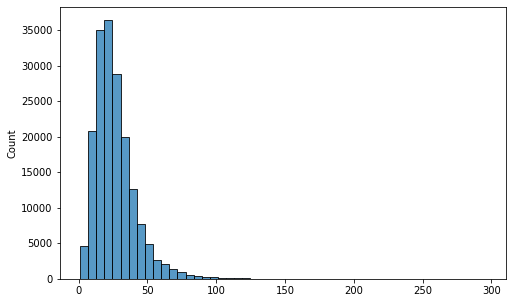

In [ ]:
# Check the distribution of number of tokens per sentence
text = train_df['text'].tolist()
sent_lengths = [len(i.split()) for i in text]

plt.figure(figsize=(8,5))
sns.histplot(data=sent_lengths, bins=50)

In [ ]:
# What should be the sentence length which covers 95% samples of the distribution
import numpy as np
max_len = np.percentile(sent_lengths, 99.925)
max_len

128.0

Most sentences in the abstract text have tokens in range of 0-50 while there are some large sentences with 300 tokens (words) in them.

Also a sentence with 128 words covers over 99.925% samples in the distribution. So we can ignore very length of large sentence and limit our inputs to only 128 words per sentence. This is the default `seq_length` for the `preprocessor_layer` which you'll see later below.


## Get list of sentences


In [ ]:
train_sentences = train_df['text'].tolist()
dev_sentences = dev_df['text'].tolist()
test_sentences = test_df['text'].tolist()

len(train_sentences), len(dev_sentences), len(test_sentences)

(180040, 30212, 30135)

## Encode the target labels in numeric format

I'll be using categorical crossentropy as loss and softmax activation which demand the target labels to be One-hot encode. So let's One-hot encode the target labels

In [ ]:
# One-hot encoding 
from sklearn.preprocessing import OneHotEncoder

ohc = OneHotEncoder(sparse=False) #don't want sparse labels
train_labels = ohc.fit_transform(train_df['target_label'].to_numpy().reshape(-1,1))
dev_labels = ohc.transform(dev_df['target_label'].to_numpy().reshape(-1,1))
test_labels = ohc.transform(test_df['target_label'].to_numpy().reshape(-1,1))

train_labels[:12]

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.]])

In [ ]:
# Label encoding
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

train_labels_encoded = le.fit_transform(train_df['target_label'].to_numpy())
dev_labels_encoded = le.transform(dev_df['target_label'].to_numpy())
test_labels_encoded = le.transform(test_df['target_label'].to_numpy())

#check how label-encoded labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

## Create positional embeddings

In [ ]:
# How many different line numbers are there?
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

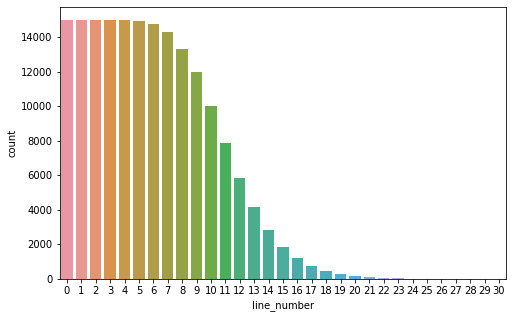

In [ ]:
# Plot the distribution of line_number column
plt.figure(figsize=(8,5))
sns.countplot(x=train_df['line_number']);

I'll be one-hot encoding the line numbers but the vector length for encoded line_numbers shall be 20 as there are very few samples with line_number >20. Even if we used 30 long vector, there are 2 disadvantages:
* The vector size increases (curse of dimensionality)
* The vectors will be very sparsed (long vectors with lots of zeros) just for sake of few samples (for line_number >20)

In [ ]:
# One-hot encoding the line_numbers
import tensorflow as tf

train_line_num_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=20)
dev_line_num_one_hot = tf.one_hot(dev_df['line_number'].to_numpy(), depth=20)
test_line_num_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=20)

train_line_num_one_hot[:12], train_line_num_one_hot.shape

(<tf.Tensor: shape=(12, 20), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0

In [ ]:
# How many different total_lines are there?
train_df['total_lines'].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

In [ ]:
# One-hot encoding the line_numbers
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
dev_total_lines_one_hot = tf.one_hot(dev_df['total_lines'].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)

train_total_lines_one_hot[:12], train_total_lines_one_hot.shape

(<tf.Tensor: shape=(12, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

# Bert PubMed model

This Bert model was pretrained on MEDLINE/PubMed from scratch. So this becomes an ideal model for us as the dataset we're using is also related to PubMed publications.

You can read more about the model on TensorFlow Hub: https://tfhub.dev/google/experts/bert/pubmed/2



## Create tf datasets with tf.data API for faster loading

In [ ]:
# Prepare data for hybrid_model
train_dataset = tf.data.Dataset.from_tensor_slices(((train_line_num_one_hot, train_total_lines_one_hot, train_sentences), train_labels))
dev_dataset = tf.data.Dataset.from_tensor_slices(((dev_line_num_one_hot, dev_total_lines_one_hot, dev_sentences), dev_labels))
test_dataset = tf.data.Dataset.from_tensor_slices(((test_line_num_one_hot, test_total_lines_one_hot, test_sentences), test_labels))

train_dataset

<TensorSliceDataset shapes: (((20,), (20,), ()), (5,)), types: ((tf.float32, tf.float32, tf.string), tf.float64)>

In [ ]:
# Batch and prefetch tf datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
dev_dataset = dev_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset shapes: (((None, 20), (None, 20), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string), tf.float64)>

## Load the Bert model and its Tokenizer

I am loading the Bert model and its Tokenizer from [TensorFlow Hub](https://tfhub.dev/google/experts/bert/pubmed/2). Tokenizer preprocesses the text (converts the text inputs into numbers) into recommended format for the input fed to the Bert model.


In [ ]:
!pip install --quiet tensorflow-text

     |████████████████████████████████| 4.9 MB 3.8 MB/s 


In [ ]:
# Importing the model and tokenizer
import tensorflow_hub as hub
import tensorflow_text as text #this import is necessary to load the preprocessor_layer below (bert_en_uncased_preprocess/3)

# Create Keras layers for Preprocessor and Bert 
preprocessor_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
                                    input_shape=[],
                                    dtype=tf.string,
                                    trainable=False,
                                    name='Bert_preprocessor')
bert_layer = hub.KerasLayer('https://tfhub.dev/google/experts/bert/pubmed/2',
                            trainable=False)

## Build a model

I'll build a functional model using the above defined `preprocessor_layer` and `bert_layer`. 

Let's understand the outputs of above mentioned layers:
* `preprocessor_layer` outputs: dictionary of 3 tensors of shape [batch_size, seq_length] (default seq_length = 128).
```
"input_word_ids": has the token ids of the input sequences.
"input_mask": has value 1 at the position of all input tokens present before padding and value 0 for the padding tokens.
"input_type_ids": has the index of the input segment that gave rise to the input token at the respective position. The first input segment (index 0) includes the start-of-sequence token and its end-of-segment token. The second segment (index 1, if present) includes its end-of-segment token. Padding tokens get index 0 again.
```
* `bert_layer` outputs: dictionary of 4 tensors. 
```
"pooled_output": has output vector of ['CLS'] token of Bert model. shape = [batch_size, 768]
"sequence_output": has output vector for each token in the sequence. shape = [batch_size, sequence_length, 768]
"encoder_outputs": has output of each of the 12 encoders in the Bert base model. shape = [batch_size, sequence_length, 768]*12
```

* Since this is a sentence classification task, we'll only need `sequence_outputs` from the `bert_layer` outputs. As per the attached resource, adding 1D CNN layers with MaxPooling on `sequence_outputs` improves the results. 

> 📖 **Resource**: https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1194/reports/custom/15739845.pdf

* I'll be using 2 extra engineered features namely: `line_number` and `total_lines`. These features will be passed as one-hot encoded vectors which will be concatenated with the output from 1D CNN layers. These concatenated features will then be passed through 2 Dense layer with dropouts then through final Dense layer with `num_classes` units and softmax activation.

**Note**: The reason of adding 2 engineered features (`line_number` and `total_lines`) is because this is a Sequential sentence classification task. The sentences in the abstract are correlated and ***derive context*** from each other.The order of the sentences matter a lot and these 2 features will help the model understand the sequence/order of the input sentences.

In [ ]:
# Build the model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, Conv1D, MaxPool1D, GlobalMaxPool1D
from tensorflow.keras import Model

# 1. Bert + CNN inputs
bert_inputs = Input(shape=(), dtype=tf.string)
preprocessed_text = preprocessor_layer(bert_inputs)
bert_outputs = bert_layer(preprocessed_text)
sequence_outputs = bert_outputs['sequence_output']
cnn_1 = Conv1D(filters=256, kernel_size=5, strides=1, padding='same', activation='relu')(sequence_outputs)
cnn_2 = Conv1D(filters=256, kernel_size=5, strides=1, padding='same', activation='relu')(cnn_1)
max_pool = GlobalMaxPool1D()(cnn_2)
bert_model = Model(bert_inputs, max_pool, name='bert_model')

# 2. line_number model
line_number_inputs = Input(shape=(20,), dtype=tf.int32)
line_number_outputs = Dense(128, activation='relu')(line_number_inputs)
line_number_model = Model(line_number_inputs, line_number_outputs, name='line_number_model')

# 3. total_lines model
total_lines_inputs = Input(shape=(20,), dtype=tf.int32) 
total_lines_outputs = Dense(128, activation='relu')(total_lines_inputs)
total_lines_model = Model(total_lines_inputs, total_lines_outputs, name='total_lines_model')

# 4. Concatenate bert_model, line_number_model & total_lines_model outputs
concat_outputs = Concatenate()([bert_model.output,
                                line_number_model.output,
                                total_lines_model.output])
dropout_1 = Dropout(0.5)(concat_outputs)
combined_dense = Dense(256, activation='relu')(dropout_1)
dropout_2 = Dropout(0.5)(combined_dense)
final_dense = Dense(256, activation='relu')(dropout_2)

# 5. Final output layer
final_outputs = Dense(num_classes, activation='softmax')(final_dense)

hybrid_model = Model(inputs = [line_number_model.input,
                               total_lines_model.input,
                               bert_model.input],
                     outputs = final_outputs, 
                     name='hybrid_model')

# Compile the model
hybrid_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                   optimizer=tf.keras.optimizers.Adam(),
                   metrics=['accuracy'])

hybrid_model.summary()

Model: "hybrid_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 Bert_preprocessor (KerasLayer)  {'input_type_ids':   0          ['input_1[0][0]']                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                               

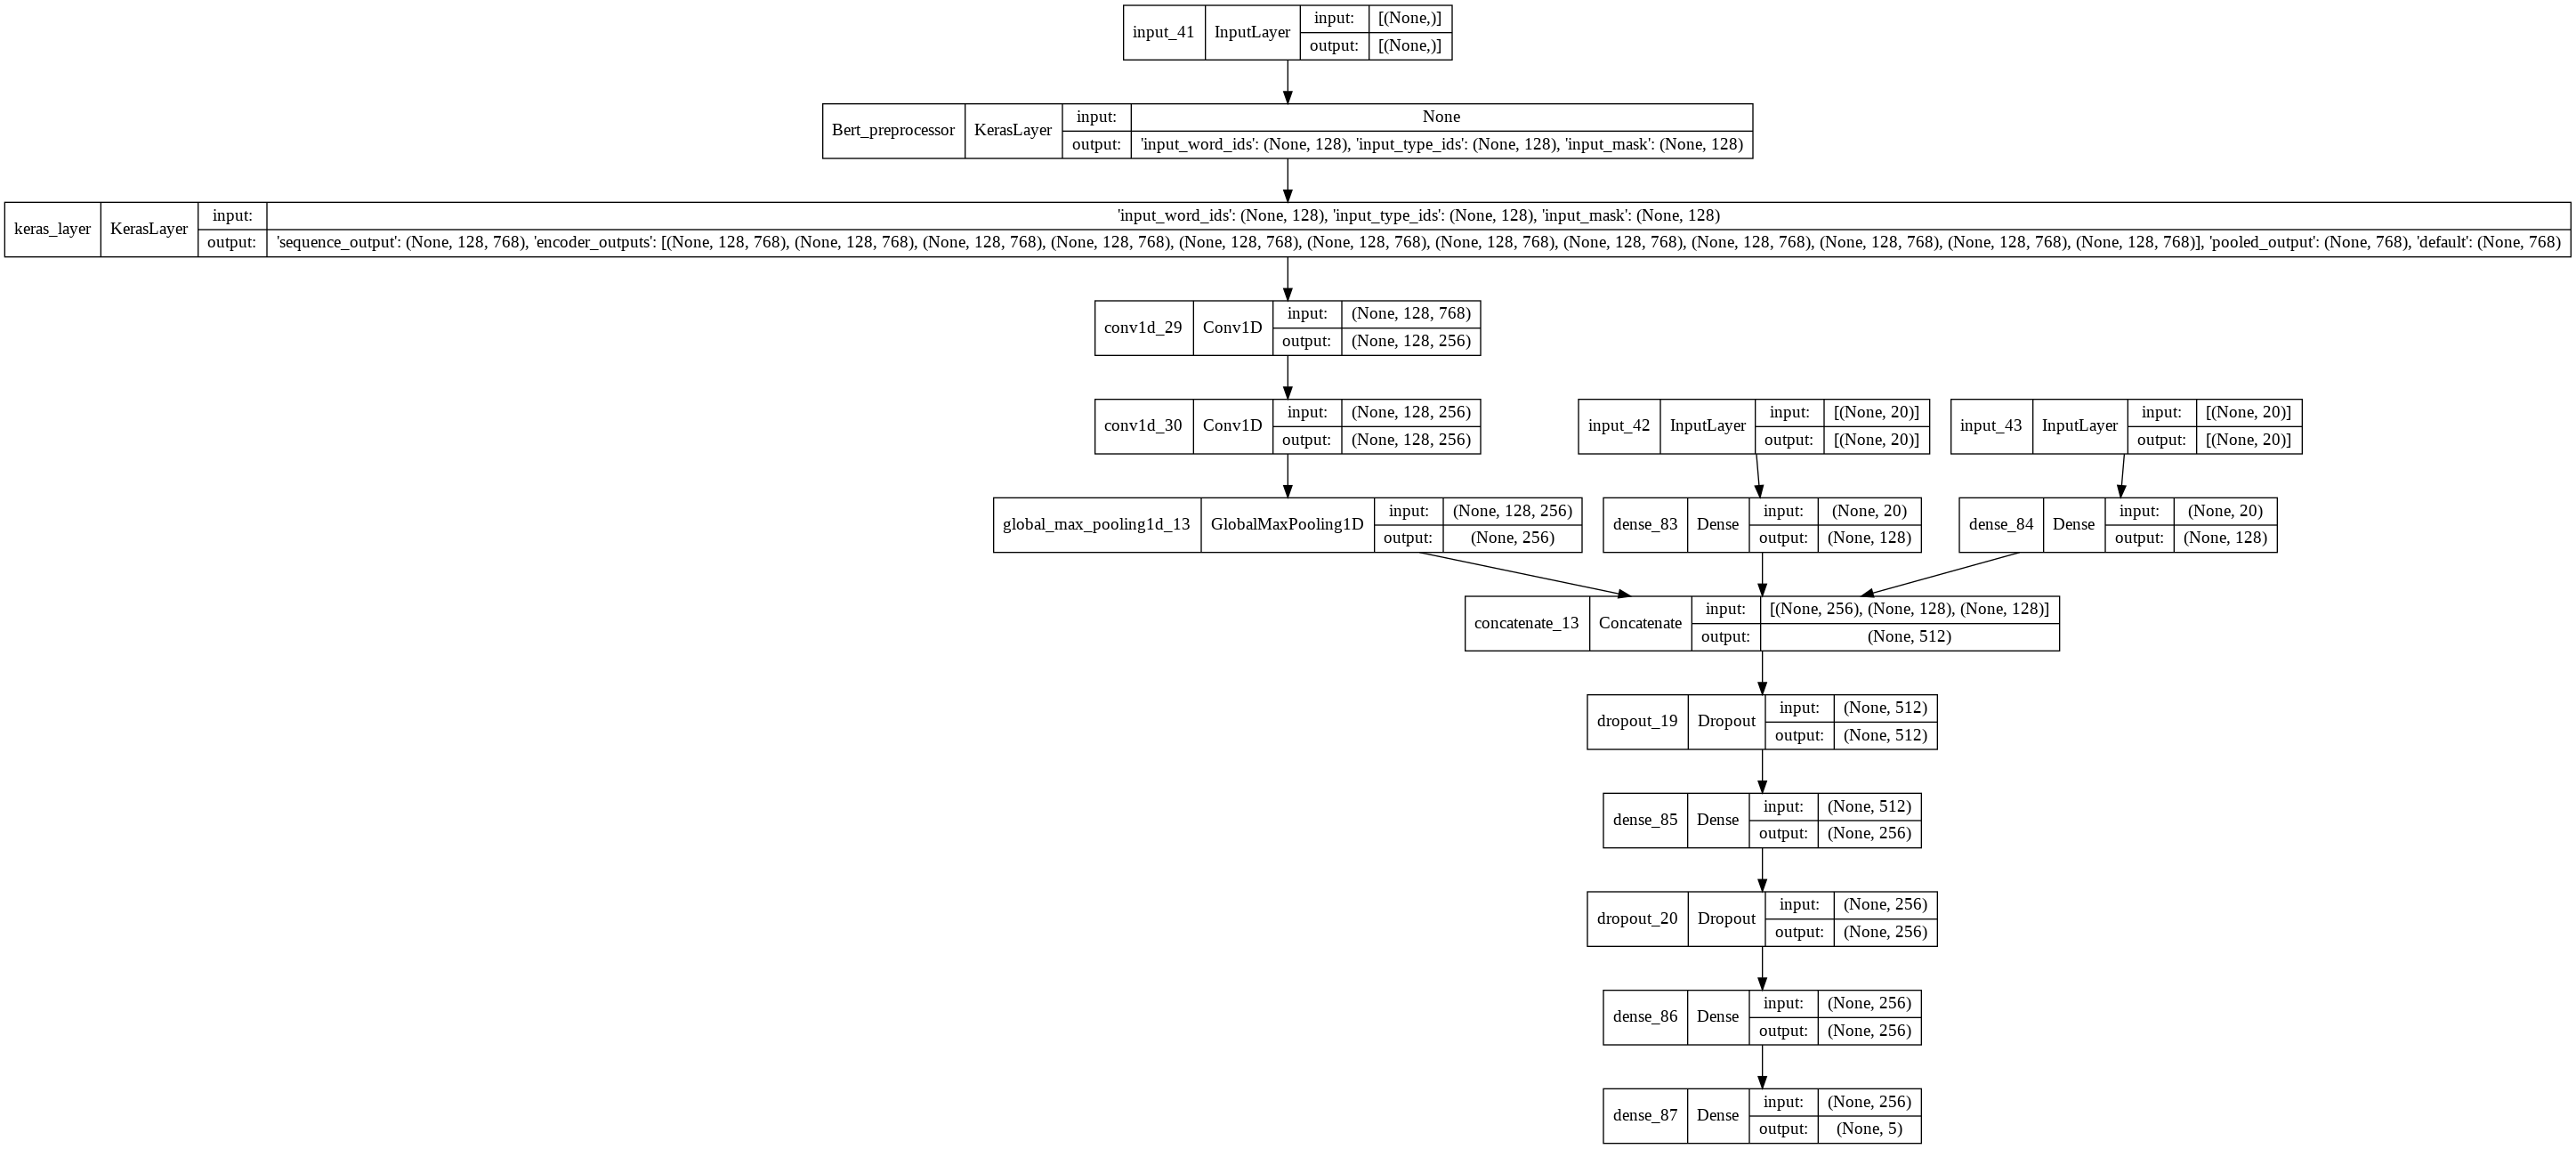

In [ ]:
# Plot the model architecture
from tensorflow.keras.utils import plot_model
plot_model(hybrid_model, show_shapes=True)

In [ ]:
# setting the model checkpoint
save_dir = 'best_model'
callback = tf.keras.callbacks.ModelCheckpoint(save_dir, monitor='val_accuracy', save_best_only=True)

In [ ]:
# Fit the model
history = best_model.fit(train_dataset,
                        validation_data=dev_dataset,
                        epochs=2,
                        callbacks=callback)

Epoch 1/2
5627/5627 [==============================] - ETA: 0s - loss: 0.8226 - accuracy: 0.9018

INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


5627/5627 [==============================] - 1463s 258ms/step - loss: 0.8226 - accuracy: 0.9018 - val_loss: 0.8132 - val_accuracy: 0.9059
Epoch 2/2
5627/5627 [==============================] - 1432s 254ms/step - loss: 0.8222 - accuracy: 0.9018 - val_loss: 0.8140 - val_accuracy: 0.9055


In [ ]:
def plot_loss_curves(history):
  """
  Plots a graph with train_loss, val_loss, train_accuracy & val_accuracy against number of epochs

  params: history - Keras object storing the train_loss, val_loss, accuracy & val_accuracy
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  epochs = range(len(history.history['loss']))

  plt.plot(epochs, loss, label='train_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.xlabel('Epochs')
  plt.title('Loss')
  plt.legend()

  plt.figure()
  plt.plot(epochs, acc, label='train_accuracy')
  plt.plot(epochs, val_acc, label='val_accuracy')
  plt.xlabel('Epochs')
  plt.title('Accuracy')
  plt.legend();

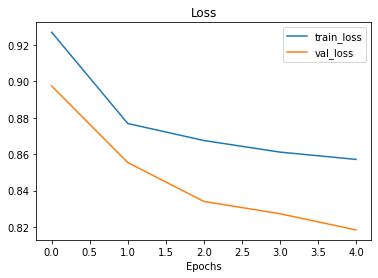

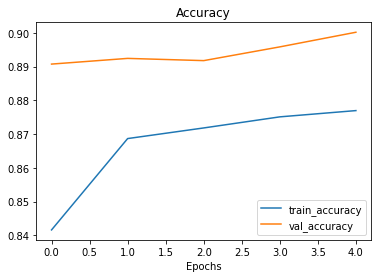

In [ ]:
plot_loss_curves(history)

## Evaluate the model

In [ ]:
# Load the saved best model
best_model = tf.keras.models.load_model('/content/best_model')

In [ ]:
# Making predictions using the model on dev data
pred_probs = best_model.predict(dev_dataset)
preds = tf.argmax(pred_probs, axis=1).numpy()
preds

array([0, 0, 0, ..., 4, 1, 1])

In [ ]:
# Making predictions using the model on test data
pred_probs_test = best_model.predict(test_dataset)
preds_test = tf.argmax(pred_probs_test, axis=1).numpy()
preds_test

array([3, 2, 2, ..., 4, 4, 1])

In [ ]:
#Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

def calculate_metrics(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a classification problem
  """
  #Calculate model accuracy
  model_accuracy= accuracy_score(y_true, y_pred)*100
  #Calculate model precision, recall and f1-score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
  model_results={'accuracy':model_accuracy,
                 'precision':model_precision,
                 'recall':model_recall,
                 'f1':model_f1}
  return model_results

In [ ]:
# Metrics for dev dataset
best_model_5_epc = calculate_metrics(dev_labels_encoded, preds)
best_model_5_epc

{'accuracy': 90.65603071627169,
 'f1': 0.9038098702085002,
 'precision': 0.9100808154689756,
 'recall': 0.9065603071627168}

In [ ]:
# Metrics for test dataset
model_metrics_test = calculate_metrics(test_labels_encoded, preds_test)
model_metrics_test

{'accuracy': 90.14103202256513,
 'f1': 0.8984951228922923,
 'precision': 0.903554017921997,
 'recall': 0.9014103202256513}

## Streamlit App

In [ ]:
!pip install streamlit
!npm install -g localtunnel
!pip install tensorflow-text

     |████████████████████████████████| 9.2 MB 14.0 MB/s 
     |████████████████████████████████| 4.3 MB 42.5 MB/s 
     |████████████████████████████████| 76 kB 6.7 MB/s 
     |████████████████████████████████| 111 kB 75.3 MB/s 
     |████████████████████████████████| 180 kB 68.7 MB/s 
     |████████████████████████████████| 164 kB 70.4 MB/s 
     |████████████████████████████████| 63 kB 2.4 MB/s 
     |████████████████████████████████| 126 kB 70.6 MB/s 
     |████████████████████████████████| 791 kB 59.9 MB/s 
     |████████████████████████████████| 374 kB 67.5 MB/s 
  Created wheel for blinker: filename=blinker-1.4-py3-none-any.whl size=13478 sha256=a872faeba38e7f1e425faaf2e65c82e3cdd4357628b63f9b3b496ba9decfd9f1
  Stored in directory: /root/.cache/pip/wheels/22/f5/18/df711b66eb25b21325c132757d4314db9ac5e8dabeaf196eab
Successfully built blinker
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      

/tools/node/bin/lt -> /tools/node/lib/node_modules/localtunnel/bin/lt.js
+ localtunnel@2.0.2
added 22 packages from 22 contributors in 1.374s
     |████████████████████████████████| 4.9 MB 14.7 MB/s 


In [ ]:
!streamlit run app.py & npx localtunnel --port 8501

/bin/bash: streamlit: command not found
npx: installed 22 in 3.463s
your url is: https://modern-bullfrog-45.loca.lt
^C
